## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

## 在本次作業中一共嘗試了三種訓練方式：L1, L2, L1_L2
* L1: 在1e-12時，模型準確度最高達0.6968 (與1e-8兩者不相上下)
* L2: 在1e-12時，模型準確度最高達0.6944 (與1e-8兩者不相上下)
* L1_L2: 在L1=1e-8, L2=1e-8時，模型準確度最高達0.6944

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## L1 regularization

In [5]:
from keras.regularizers import l1, l2, l1_l2

#建立神經網路，並加入 L1

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
# 使用迴圈建立不同的帶不同 L1 的模型並訓練

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0804 00:43:59.258756 21812 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 00:43:59.259756 21812 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 00:43:59.274757 21812 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 00:43:59.275757 21812 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 00:43:59.277757 21812 depr

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 202us/step - loss: 5.9980 - acc: 0.2759 - val_loss: 5.8026 - val_acc: 0.3486
Epoch 2/50
50000/50000 [==============================] - 11s 221us/step - loss: 5.7147 - acc: 0.3665 - val_loss: 5.6405 - val_acc: 0.3843
Epoch 3/50
50000/50000 [==============================] - 10s 205us/step - loss: 5.5743 - acc: 0.3938 - val_loss: 5.5166 - val_acc: 0.4051
Epoch 4/50
50000/50000 [==============================] - 11s 212us/step - loss: 5.4540 - acc: 0.4159 - val_loss: 5.4011 - val_acc: 0.4157
Epoch 5/50
50000/50000 [==============================] - 9s 188us/step - loss: 5.3430 - acc: 0.4308 - val_loss: 5.2939 - val_acc: 0.4344
Epoch 6/50
50000/50000 [==============================] - 10s 190us/step - loss: 5.2411 - acc: 0.4458 - val_loss: 5.2076 - val_acc: 0.4390
Epoch 7/50
50000/50000 [==============================] - 9s 189us/step - loss: 5.1460 - acc: 0.4574 - val_loss: 5.13

Epoch 2/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.8051 - acc: 0.3647 - val_loss: 1.7547 - val_acc: 0.3857
Epoch 3/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.7222 - acc: 0.3957 - val_loss: 1.6948 - val_acc: 0.4024
Epoch 4/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6646 - acc: 0.4149 - val_loss: 1.6505 - val_acc: 0.4212
Epoch 5/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.6174 - acc: 0.4346 - val_loss: 1.6097 - val_acc: 0.4350
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5772 - acc: 0.4479 - val_loss: 1.5679 - val_acc: 0.4460
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5409 - acc: 0.4617 - val_loss: 1.5450 - val_acc: 0.4526
Epoch 8/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5102 - acc: 0.4706 - val_loss: 1.5139 - val_acc: 0.4665
Epoch 9/50
50000/50000 [==========

50000/50000 [==============================] - 9s 186us/step - loss: 1.7048 - acc: 0.4043 - val_loss: 1.6778 - val_acc: 0.4105
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.6467 - acc: 0.4246 - val_loss: 1.6348 - val_acc: 0.4274
Epoch 5/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.6030 - acc: 0.4399 - val_loss: 1.6036 - val_acc: 0.4277
Epoch 6/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5652 - acc: 0.4506 - val_loss: 1.5729 - val_acc: 0.4426
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5326 - acc: 0.4637 - val_loss: 1.5402 - val_acc: 0.4533
Epoch 8/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5029 - acc: 0.4746 - val_loss: 1.5143 - val_acc: 0.4646
Epoch 9/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4756 - acc: 0.4834 - val_loss: 1.5124 - val_acc: 0.4602
Epoch 10/50
50000/50000 [====================

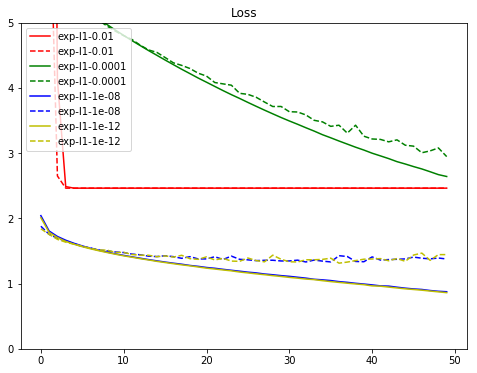

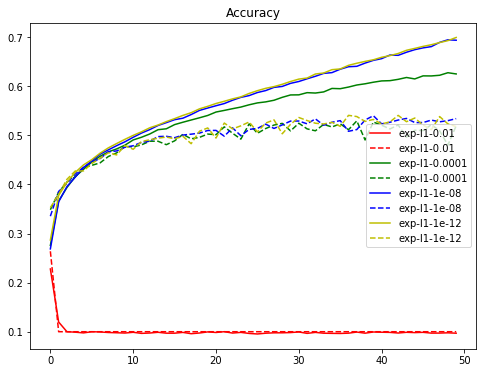

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## L2 regularization

In [9]:
#建立神經網路，並加入 L2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 193us/step - loss: 2.1729 - acc: 0.2734 - val_loss: 1.9958 - val_acc: 0.3534
Epoch 2/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.9413 - acc: 0.3689 - val_loss: 1.8941 - val_acc: 0.3770
Epoch 3/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.8638 - acc: 0.3968 - val_loss: 1.8313 - val_acc: 0.4075
Epoch 4/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.8071 - acc: 0.4166 - val_loss: 1.7816 - val_acc: 0.4234
Epoch 5/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7629 - acc: 0.4326 - val_loss: 1.7517 - val_acc: 0.4273
Epoch 6/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7249 - acc: 0.4451 - val_loss: 1.7232 - val_acc: 0.4389
Epoch 7/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.6922 - acc: 0.4541 - val_loss: 1.6954 -

50000/50000 [==============================] - 9s 185us/step - loss: 1.8138 - acc: 0.3625 - val_loss: 1.7622 - val_acc: 0.3895
Epoch 3/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.7254 - acc: 0.3944 - val_loss: 1.6921 - val_acc: 0.4053
Epoch 4/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6663 - acc: 0.4162 - val_loss: 1.6442 - val_acc: 0.4223
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6206 - acc: 0.4310 - val_loss: 1.6057 - val_acc: 0.4325
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5812 - acc: 0.4446 - val_loss: 1.5847 - val_acc: 0.4428
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5472 - acc: 0.4559 - val_loss: 1.5576 - val_acc: 0.4510
Epoch 8/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5158 - acc: 0.4664 - val_loss: 1.5330 - val_acc: 0.4581
Epoch 9/50
50000/50000 [=====================

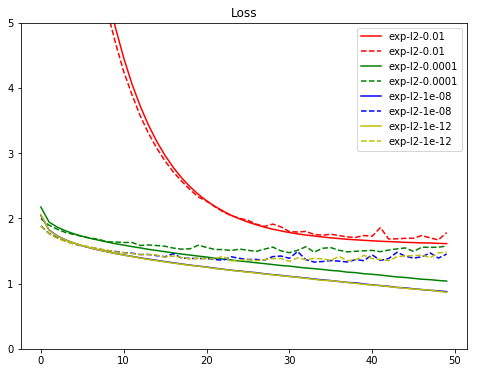

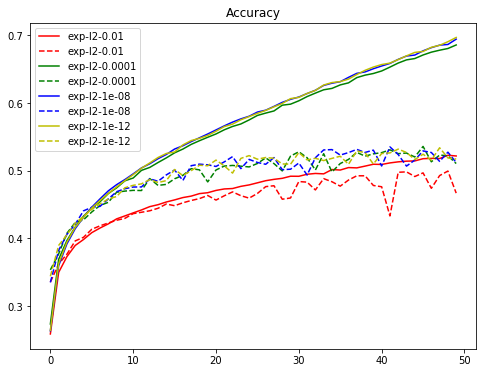

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## L1_L2 (l1=N, l2=N) regularization

In [13]:
#建立神經網路，並加入 L1_L2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-8]
L2_EXP = [1e-2, 1e-8]

In [15]:
import itertools

results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for l1, l2 in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 Regulizer = %.8f" % (l1) + ", and L2 Regulizer = %.8f" % (l2))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(l1) + ", exp-l2-%s" % str(l2)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 Regulizer = 0.01000000, and L2 Regulizer = 0.01000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/5

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 224us/step - loss: 198.6194 - acc: 0.2457 - val_loss: 41.0932 - val_acc: 0.2481
Epoch 2/50
50000/50000 [==============================] - 11s 211us/step - loss: 19.0856 - acc: 0.1198 - val_loss: 7.2763 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 11s 212us/step - loss: 4.1019 - acc: 0.0992 - val_loss: 2.6436 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.4854 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.4626 - acc: 0.0997 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.4626 - acc: 0.0963 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 11s 210us/step - loss: 2.4626 - acc: 0.0983 - val_loss

50000/50000 [==============================] - 11s 230us/step - loss: 2.0367 - acc: 0.2667 - val_loss: 1.8695 - val_acc: 0.3500
Epoch 2/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.8149 - acc: 0.3635 - val_loss: 1.7660 - val_acc: 0.3845
Epoch 3/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.7324 - acc: 0.3917 - val_loss: 1.6977 - val_acc: 0.4089
Epoch 4/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.6729 - acc: 0.4131 - val_loss: 1.6532 - val_acc: 0.4216
Epoch 5/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.6254 - acc: 0.4323 - val_loss: 1.6179 - val_acc: 0.4360
Epoch 6/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.5848 - acc: 0.4451 - val_loss: 1.5877 - val_acc: 0.4427
Epoch 7/50
50000/50000 [==============================] - 11s 218us/step - loss: 1.5484 - acc: 0.4593 - val_loss: 1.5495 - val_acc: 0.4554
Epoch 8/50
50000/50000 [==============

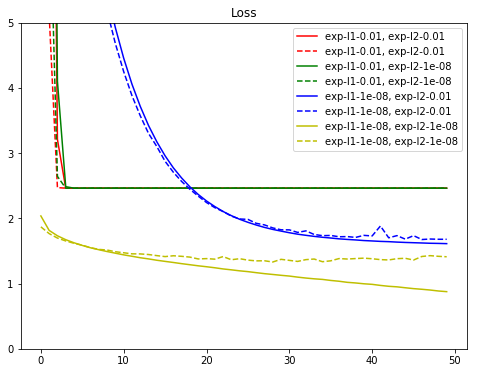

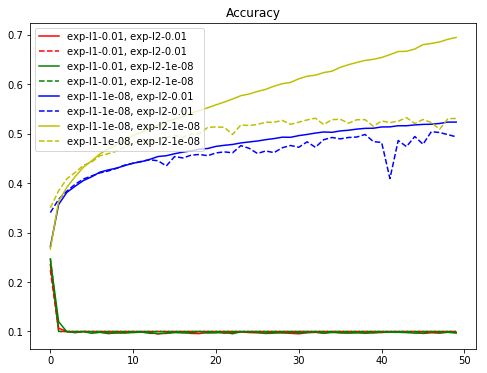

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()